In [1]:
AOI = 'POLYGON ((30.2759366834769 48.51505083641415, 30.61727452548106 48.45927941996875, 30.64285389693346 48.5330821966183, 30.30277405680401 48.58843427910546, 30.2759366834769 48.51505083641415))'
START_DATE = "2020-05-01"
END_DATE = "2020-06-30"

### Detecting boundaries for given AOI

In [2]:
import os
import time
import cv2
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio.mask
import tempfile
import shapely
import re

from tqdm import tqdm
from os.path import join, basename, split
from skimage import measure
from scipy.ndimage import rotate
from rasterio.features import rasterize, shapes
from shapely.geometry import Polygon, shape, LinearRing
import shapely.wkt
from pathlib import Path
from datetime import datetime
import yaml

from sentinel2download.downloader import Sentinel2Downloader
from sip_plot_boundary_detection_nn.code.preprocessing import (
    preprocess_sentinel_raw_data, read_raster, extract_tci)
from sip_plot_boundary_detection_nn.code.engine import *
from sip_plot_boundary_detection_nn.code.dataset import BoundaryDetector
from sip_plot_boundary_detection_nn.code.filter_polygons import filter_polygons

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import torch.cuda as cuda
cuda.empty_cache()

In [4]:
default_crs = 'EPSG:4326'

polygon = shapely.wkt.loads(AOI)
aoi_filename = f"{time.time()}_aoi.geojson"
gpd.GeoDataFrame(gpd.GeoSeries([polygon]), columns=["geometry"]).to_file(aoi_filename, driver="GeoJSON")
start_date = datetime.strptime(START_DATE, '%Y-%m-%d')
end_date = datetime.strptime(END_DATE, '%Y-%m-%d')

In [5]:
def get_tiles(aoi_path, sentinel_tiles_path):
    '''
    Returns Sentinel-2 tiles that intersects with specified AoI.

        Parameters:
            aoi_path (str): Path to geojson/shp file with AoI to process.
            sentinel_tiles_path (str): Path to geojson/shp file with all Sentinel-2 tiles.

        Returns:
            date_tile_info (GeoDataFrame): Filtered tiles (tileID, geometry, date).
    '''
    aoi_file = gpd.read_file(aoi_path)
    sentinel_tiles = gpd.read_file(sentinel_tiles_path)
    print(aoi_file.crs, sentinel_tiles.crs)
    sentinel_tiles.set_index("Name", drop=False, inplace=True)

    best_interseciton = {"tileID": [], "geometry": []}
    rest_aoi = aoi_file.copy()

    while rest_aoi.area.sum() > 0:
        res_intersection = gpd.overlay(rest_aoi, sentinel_tiles, how="intersection")
        biggest_area_idx = res_intersection.area.argmax()

        tileID = res_intersection.loc[biggest_area_idx, "Name"]
        this_aoi = res_intersection.loc[biggest_area_idx, "geometry"]

        best_interseciton["tileID"].append(tileID)
        best_interseciton["geometry"].append(this_aoi)

        biggest_intersection = sentinel_tiles.loc[[tileID]]
        rest_aoi = gpd.overlay(rest_aoi, biggest_intersection, how="difference")
        sentinel_tiles = sentinel_tiles.loc[res_intersection["Name"]]

    date_tile_info = gpd.GeoDataFrame(best_interseciton)
    date_tile_info.crs = aoi_file.crs
    
    return date_tile_info


In [6]:
def process_polygons(result_df, current_crs, limit=500, dst_crs="EPSG:4326"):
    """
    Prepare result Dataframe with polygons

        Parameters:
            result_df (pd.DataFrame): Result DataFrame
            limit (int): min area for polygon in m2
        Returns:
            GeoDataFrame: GeoDataFrame ready for saving
    """

    gdf = gpd.GeoDataFrame(result_df)
    gdf.crs = current_crs

    gdf.to_crs(dst_crs, inplace=True)
    return gdf


def save_polygons(gdf, save_path):
    if len(gdf) == 0:
        print('No polygons detected.')
        return

    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    save_path = save_path + ".temp" 
    gdf.to_file(save_path, driver='GeoJSON')
    os.rename(save_path, save_path[:-5])
    
    return gdf

### Find tile indexes

In [7]:
BASE = f"/home/{os.getenv('NB_USER')}/work"

API_KEY = os.path.join(BASE, ".secret/sentinel2_google_api_key.json")
LOAD_DIR = os.path.join(BASE, "satellite_imagery")
RESULTS_DIR = os.path.join(BASE, "results/pbdnn")
PBD_DIR = os.path.join(BASE, "notebooks/pbdnn")

BANDS = {'TCI'}
CONSTRAINTS = {'NODATA_PIXEL_PERCENTAGE': 15.0, 'CLOUDY_PIXEL_PERCENTAGE': 40.0, }
PRODUCT_TYPE = 'L2A'

In [8]:
local = False
if local:
    ukr_shapefile = os.path.join(BASE, "data/notebooks/pbdnn/sip_plot_boundary_detection_nn/ukr_shapes/custom.geo.json")
    usa_shapefile = os.path.join(BASE, "data/notebooks/pbdnn/sip_plot_boundary_detection_nn/usa_shapes/custom.geo.json")
    config_file = os.path.join(BASE, "data/notebooks/pbdnn/sip_plot_boundary_detection_nn/code/config.yaml")
    API_KEY = os.path.join(BASE, "data/notebooks/pbdnn/sentinel2_google_api_key.json")
    PBD_DIR = os.path.join(BASE, "data/notebooks/pbdnn")
else:
    ukr_shapefile = os.path.join(BASE, "notebooks/pbdnn/sip_plot_boundary_detection_nn/ukr_shapes/custom.geo.json")
    usa_shapefile = os.path.join(BASE, "notebooks/pbdnn/sip_plot_boundary_detection_nn/usa_shapes/custom.geo.json")
    config_file = os.path.join(BASE, "notebooks/pbdnn/sip_plot_boundary_detection_nn/code/config.yaml")


with open(config_file) as f:
    config = yaml.safe_load(f)

### Check location before filtering non-agricultural lands

In [9]:
ukraine = gpd.read_file(ukr_shapefile)
usa = gpd.read_file(usa_shapefile)
aoi = gpd.read_file(aoi_filename)

if local:
    if (1*aoi.intersects(ukraine)).sum():
        filter_path = os.path.join(
            BASE, "data/notebooks/pbdnn/sip_plot_boundary_detection_nn/ukr_shapes/ukr_non_agriculture.geojson")
    elif (1*aoi.intersects(usa)).sum():
        filter_path = os.path.join(
            BASE, "data/notebooks/pbdnn/sip_plot_boundary_detection_nn/usa_shapes/us_shape.geojson")
    else:
        print('Data to filter out predictions is not collected yet, prosseding with no filtering')
        filter_path = None
else:
    if (1*aoi.intersects(ukraine)).sum():
        filter_path = os.path.join(
            BASE, "notebooks/pbdnn/sip_plot_boundary_detection_nn/ukr_shapes/ukr_non_agriculture.geojson")
    elif (1*aoi.intersects(usa)).sum():
        filter_path = os.path.join(
            BASE, "notebooks/pbdnn/sip_plot_boundary_detection_nn/usa_shapes/us_shape.geojson")
    else:
        print('Data to filter out predictions is not collected yet, prosseding with no filtering')
        filter_path = None

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Download data

In [10]:
def _check_folder(tile_folder, file, limit, nodata):
    with rasterio.open(os.path.join(tile_folder, file)) as src:              
        # Read in image as a numpy array
        array = src.read(1)
        # Count the occurance of NoData values in np array
        nodata_count = np.count_nonzero(array == nodata)
        # Get a % of NoData pixels
        nodata_percentage = round(nodata_count / array.size * 100, 2)
        print(f"NODATA_PIXEL_PERCENTAGE for {tile_folder} images: {nodata_percentage}%")
        if nodata_percentage <= limit:
            return True
        else:
            return False

In [11]:
def check_nodata(loadings, product_type, limit=15.0, nodata=0):
    filtered = dict()
    
    print(f"Checking NODATA_PIXEL_PERCENTAGE for {product_type}")            
    
    for tile, folders in loadings.items():
        filtered_folders = set()
        for folder in folders:
            for file in os.listdir(folder):
                if file.endswith(".jp2") and "OPER" not in file:
                    if product_type == 'L1C' and limit:
                         if _check_folder(folder, file, limit, nodata):
                            filtered_folders.add(folder)
                            break
                    else:
                        filtered_folders.add(folder)
        filtered[tile] = filtered_folders
    return filtered

In [12]:
def filter_date(loadings):
    def _find_last_date(folders):        
        dates = list()
        for folder in folders:
            search = re.search(r"_(\d+)T\d+_", str(folder))
            date = search.group(1)
            date = datetime.strptime(date, '%Y%m%d')
            dates.append(date)    
        last_date = max(dates)
        last_date = datetime.strftime(last_date, '%Y%m%d')
        return last_date
    
    filtered = dict()
    for tile, folders in loadings.items():
        
        try:
            last_date = _find_last_date(folders)
            for folder in folders:
                if last_date in folder:
                    filtered[tile] = folder
        except Exception as ex:
            print(f"Error for {tile}: {str(ex)}")
    return filtered

In [13]:
def load_images(api_key, tiles, start_date, end_date, output_dir, product_type="L2A"):
    loader = Sentinel2Downloader(api_key)
    loadings = dict()
    for tile in tiles:
        print(f"Loading images for tile: {tile}...")
        loaded = loader.download(product_type,
                                 [tile],
                                 start_date=start_date,
                                 end_date=end_date,
                                 output_dir=output_dir,                       
                                 bands=BANDS,
                                constraints=CONSTRAINTS)
        
        print(f"Loading images for tile {tile} finished")
        loadings[tile] = loaded
    
    tile_folders = dict()
    for tile, tile_paths in loadings.items():
        tile_folders[tile] = {str(Path(tile_path[0]).parent) for tile_path in tile_paths}
    return tile_folders

In [14]:
# Credit for baseline: work/notebooks/pw/raster_predict.ipynb
def create_style(class_):
    colors = dict(boundary='#e80e27')
    
    style = dict(color=colors.get(class_.lower(), '#C0C0C0'),
                stroke='#e80e27')
    style['stroke-width'] = 2
    return str(style)

In [15]:
sentinel_tiles_path = "sentinel2grid.geojson"
model = make_unet_plusplus()
#config['model_weights_path'] = 'sip_plot_boundary_detection_nn/models/UnetPlusPlus_imagenet_60_new_dataset_v1.pth'
#config['model_weights_path'] = 'sip_plot_boundary_detection_nn/models/UnetPlusPlus_imagenet_60.pth'
#config['model_weights_path'] = 'sip_plot_boundary_detection_nn/models/UnetPlusPlus_imagenet_60_new_dataset_v2.pth'

if local:
    config['model_weights_path'] = os.path.join(
        BASE, 'data/notebooks/pbdnn/sip_plot_boundary_detection_nn/models/chkpt_UnetPlusPlus_imagenet_200_new_dataset_v3.pt')
else:
    config['model_weights_path'] = os.path.join(
        BASE, 'notebooks/pbdnn/sip_plot_boundary_detection_nn/models/chkpt_UnetPlusPlus_imagenet_200_new_dataset_v3.pt')

try:
    model.load_state_dict(torch.load(config['model_weights_path']))
    config['device'] = 'cuda'
except Exception:
    model.load_state_dict(torch.load(
        config['model_weights_path'],map_location=torch.device('cpu')))
    config['device'] = 'cpu'
    
date_tile_info = get_tiles(aoi_filename, sentinel_tiles_path)
loadings = load_images(API_KEY, date_tile_info.tileID.values, START_DATE, END_DATE, LOAD_DIR, PRODUCT_TYPE)
checked = check_nodata(loadings, PRODUCT_TYPE)
filtered = filter_date(checked)
    
origin_name = os.path.basename(aoi_filename).replace(".geojson", "")

detector = BoundaryDetector(model, tiles_dir='/home/jovyan/work/satellite_imagery')

epsg:4326 epsg:4326
Loading images for tile: 35UQP...
Loading images for tile 35UQP finished
Checking NODATA_PIXEL_PERCENTAGE for L2A


In [20]:
result_df = pd.DataFrame([])
with tempfile.TemporaryDirectory(dir=PBD_DIR) as tmpdirname:   
    for i, tile in tqdm(date_tile_info.iterrows(), total=date_tile_info.shape[0]):
        try:
            tile_folder = Path(filtered[tile.tileID])
            print(tile_folder)
        except Exception as ex:
            print(f"Error for {tile.tileID}: {str(ex)}")
            continue

        raster_path = preprocess_sentinel_raw_data(
            save_path=tmpdirname,
            tile_folder=tile_folder,
            aoi_mask=date_tile_info.loc[[i]]
        )
            
        out_raster = raster_path.replace('_cropped', '_prediction')
        out_geom = aoi_filename.replace('_aoi.', '_prediction.')

        pred_tif_path = detector.raster_prediction(in_raster_path=raster_path,
                                                    out_raster_path=out_raster,
                                                    aoi_path=aoi_filename,
                                                    conf_thresh=0.25)

        polygons = detector.process_raster_predictions(pred_tif_path,
                                                        shapes_path=out_geom,
                                                        aoi_path=aoi_filename, 
                                                        conf_thresh=0.25)
        polygons = gpd.GeoDataFrame(polygons)
        
        if filter_path is not None:
            filters = gpd.read_file(filter_path)
            aoi = gpd.read_file(aoi_filename).to_crs(filters.crs)
            
            valid_geoms = filters.geometry.is_valid.sum() == filters.shape[0]
            if not valid_geoms:
                filters['geometry'] = filters.buffer(0)
            
            filters = filters[filters.intersects(aoi.geometry.values[0])]
            polys = filter_polygons(polygons, filters)

        df = pd.DataFrame({"geometry": polys.geometry})        
        df["id"] = pd.Series(map(lambda x: f"{origin_name}_{x}", df.index.values))
        df["tileID"] = tile.tileID
        df["start_date"] = START_DATE
        df["end_date"] = END_DATE

        result_df = pd.concat([result_df, df])

        print(f"Finished processing {tile.tileID}")
gdf = process_polygons(result_df, filters.crs)
gdf['class_'] = 'boundary'
gdf['style'] = gdf.class_.apply(lambda cl: create_style(cl))
save_path = os.path.join(RESULTS_DIR, f"{origin_name}_prediction.geojson")
save_polygons(gdf, save_path)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/jovyan/work/satellite_imagery/S2A_MSIL2A_20200626T085601_N0214_R007_T35UQP_20200626T114622



100%|██████████| 13/13 [00:01<00:00, 12.82it/s]


Writing raster: /home/jovyan/work/notebooks/pbdnn/tmpzk726wph/S2A_MSIL2A_20200626T085601_N0214_R007_T35UQP_20200626T114622_prediction.tif



100%|██████████| 766/766 [00:00<00:00, 1267.96it/s]


Writing resulting polygons: 1613430681.5415576_prediction.geojson


100%|██████████| 1/1 [02:22<00:00, 142.69s/it]

Finished processing 35UQP


,geometry,id,tileID,start_date,end_date,class_,style
0,"POLYGON ((30.61359 48.46028, 30.61317 48.46003...",1613430681.5415576_aoi_0,35UQP,2020-05-01,2020-06-30,boundary,"{'color': '#e80e27', 'stroke': '#e80e27', 'str..."
4,"POLYGON ((30.61551 48.46445, 30.61592 48.46444...",1613430681.5415576_aoi_10,35UQP,2020-05-01,2020-06-30,boundary,"{'color': '#e80e27', 'stroke': '#e80e27', 'str..."
6,"POLYGON ((30.59497 48.46474, 30.59511 48.46482...",1613430681.5415576_aoi_12,35UQP,2020-05-01,2020-06-30,boundary,"{'color': '#e80e27', 'stroke': '#e80e27', 'str..."
7,"POLYGON ((30.60608 48.46304, 30.60595 48.46313...",1613430681.5415576_aoi_13,35UQP,2020-05-01,2020-06-30,boundary,"{'color': '#e80e27', 'stroke': '#e80e27', 'str..."
10,"POLYGON ((30.58031 48.46609, 30.58045 48.46618...",1613430681.5415576_aoi_16,35UQP,2020-05-01,2020-06-30,boundary,"{'color': '#e80e27', 'stroke': '#e80e27', 'str..."
...,...,...,...,...,...,...,...
758,"POLYGON ((30.31226 48.58427, 30.31278 48.58389...",NaN,35UQP,2020-05-01,2020-06-30,boundary,"{'color': '#e80e27', 'stroke': '#e80e27', 'str..."
760,"POLYGON ((30.32893 48.58406, 30.32907 48.58414...",NaN,35UQP,2020-05-01,2020-06-30,boundary,"{'color': '#e80e27', 'stroke': '#e80e27', 'str..."
762,"POLYGON ((30.31563 48.58597, 30.31605 48.58623...",NaN,35UQP,2020-05-01,2020-06-30,boundary,"{'color': '#e80e27', 'stroke': '#e80e27', 'str..."
763,"POLYGON ((30.31350 48.58666, 30.31391 48.58665...",NaN,35UQP,2020-05-01,2020-06-30,boundary,"{'color': '#e80e27', 'stroke': '#e80e27', 'str..."


In [21]:
save_path

'/home/jovyan/work/results/pbdnn/1613430681.5415576_aoi_prediction.geojson'

<AxesSubplot:>

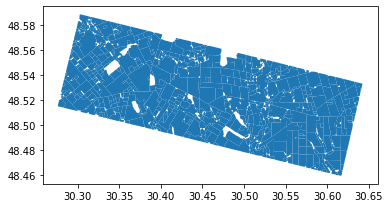

In [23]:
gdf.plot()